Modified copy of PSTs plot_stat_file.py borrowed from

https://gitlab.com/ska-telescope/pst/ska-pst/-/blob/main/python/src/ska_pst/stat/plot_stat_file.py

turned ito a notebook to demonstrate viable usage on our stack

Loading relevant libraries

In [4]:
import logging
import pathlib

In [5]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

Saving filename with stat data

In [14]:
pcap_stat_file_name = "/mnt/cnic-data/pcap/kerr/5453/stat/2025-01-25-20:26:09_0000000000000000_000000.h5"

Logger setup

In [6]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Relevant stat analysis sample

In [ ]:
def plot_set_file(stat_filename: pathlib.Path, contour_plots: bool = False, save_filename: str = "") -> None:
    """
    Plot the PST STAT output statistics saved in the given filename.

    :param stat_filename: the path to the file from which to load the statistics
    :type stat_filename: pathlib.Path
    :param contour_plots: plot 2D histogram using contours (True) or pixels (False)
    :type contour_plots: bool
    :param save_filename: the path to which the output plot will be saved
    :type save_filename: str
    """
    with h5py.File(stat_filename, "r") as f:
        logger.debug(f"Keys in stat file: {f.keys()}")

        mean_key = "MEAN_FREQUENCY_AVG"
        mean_fs_obj = f[mean_key]
        mean_arr = mean_fs_obj[()]
        logger.info(f"Means [pol,dim]={mean_arr.flatten()}")  # pylint: disable=no-member

        var_key = "VARIANCE_FREQUENCY_AVG"
        var_fs_obj = f[var_key]
        var_arr = np.sqrt(var_fs_obj[()])
        logger.info(f"Stddev [pol,dim]={var_arr.flatten()}")

        sg_key = "SPECTROGRAM"
        sg_ds_obj = f[sg_key]  # returns a h5py dataset object
        sg_arr = sg_ds_obj[()]  # returns a numpy array
        logger.info(f"Shape of {sg_key} array: {sg_arr.shape}")  # pylint: disable=no-member
        sg_arr.shape[1]  # pylint: disable=no-member
        sg_arr.shape[2]  # pylint: disable=no-member

        ts_key = "TIMESERIES"
        ts_ds_obj = f[ts_key]  # returns a h5py dataset object
        ts_arr = ts_ds_obj[()]  # returns a numpy array
        logger.info(f"Shape of {ts_key} array: {ts_arr.shape}")  # pylint: disable=no-member
        ts_arr.shape[1]  # pylint: disable=no-member
        ts_arr.shape[2]  # pylint: disable=no-member
        mean0 = ts_arr[0].transpose()  # pylint: disable=no-member
        mean1 = ts_arr[1].transpose()  # pylint: disable=no-member

        bp_key = "MEAN_SPECTRAL_POWER"
        bp_ds_obj = f[bp_key]
        bp_arr = bp_ds_obj[()].transpose()  # pylint: disable=no-member
        logger.info(f"Shape of {bp_key} array: {bp_arr.shape}")

        hist_key = "HISTOGRAM_1D_FREQ_AVG"
        hist_ds_obj = f[hist_key]  # returns a h5py dataset object
        hist_arr = hist_ds_obj[()]  # returns a numpy array
        logger.info(f"Shape of {hist_key} array: {hist_arr.shape}")  # pylint: disable=no-member
        nbin = hist_arr.shape[2]  # pylint: disable=no-member
        xbins = np.arange(-nbin / 2, nbin / 2)

        # need to find the first non zero value
        sbins = np.zeros((2, 2), dtype=int)
        ebins = np.zeros((2, 2), dtype=int)
        sbins.fill(nbin)
        ebins.fill(nbin)
        for i in range(2):
            for j in range(2):
                for k in range(nbin):
                    if sbins[i][j] == nbin and hist_arr[i][j][k] > 0:
                        sbins[i][j] = k
                for k in range(nbin):
                    if ebins[i][j] == nbin and hist_arr[i][j][(nbin - 1) - k] > 0:
                        ebins[i][j] = (nbin - 1) - k
        ibin = np.amin(sbins)
        jbin = np.amax(ebins)
        mid_bin = nbin / 2
        max_dist_bin = max(abs(mid_bin - ibin), abs(mid_bin - jbin))
        ibin = max(0, int(mid_bin - max_dist_bin))
        jbin = min(nbin - 1, int(mid_bin + max_dist_bin))

        hist2d_key = "HISTOGRAM_REBINNED_2D_FREQ_AVG"
        hist2d_ds_obj = f[hist2d_key]  # returns a h5py dataset object
        hist2d_arr = hist2d_ds_obj[()]  # returns a numpy array
        logger.info(f"Shape of {hist2d_key} array: {hist2d_arr.shape}")  # pylint: disable=no-member
        nrebin = hist2d_arr.shape[2]  # pylint: disable=no-member

        fig = plt.figure(figsize=(8, 8))
        fig.suptitle("PST Voltage Recorder Statistics")

        # generating plots
        gs = plt.GridSpec(5, 2, wspace=0.5, hspace=0.3)
        ax1 = plt.subplot(gs[0, :])
        ax2 = plt.subplot(gs[1, :])
        ax3 = plt.subplot(gs[2, :])
        ax4 = plt.subplot(gs[3:, 0])
        ax5 = plt.subplot(gs[3:, 1])

        mean = np.mean(sg_arr[0])
        stddev = np.std(sg_arr[0])
        minval = mean - 2 * stddev
        maxval = mean + 2 * stddev
        ax1.imshow(sg_arr[0], origin="lower", vmin=minval, vmax=maxval, aspect="auto")
        ax1.set_ylabel("Channel")

        ax2.plot(mean0[2], label="polA")
        ax2.plot(mean1[2], label="polB")
        ax2.set_ylabel("Power")
        ax2.set_xlabel("Time Sample")

        ax3.plot(bp_arr, label=["polA", "polB"])
        ax3.set_xlabel("Channel")
        ax3.set_ylabel("Power")

        ax4.set_xlim(xbins[ibin], xbins[jbin])
        ax4.plot(xbins, hist_arr[0][0], label="polA")
        ax4.plot(xbins, hist_arr[1][0], label="polB")
        ax4.set_xlabel("Input state")
        ax4.set_ylabel("Counts")
        ax4.legend()

        n = nrebin / 2
        if contour_plots:
            x = np.arange(-n, n)
            y = np.arange(-n, n)
            ax5.contour(x, y, hist2d_arr[0])
        else:
            ax5.imshow(hist2d_arr[0], origin="lower", aspect="auto", extent=(-n, n, -n, n))

        ax5.set_xlabel("Real")
        ax5.set_ylabel("Imag")

        if not save_filename:
            plt.show()
        else:
            plt.savefig(save_filename)

        print("\nShowcasing direct access to stats data and metadata for automated testing\n")
        print(f"Keys in stat file: {f.keys()}")
        print(f"Stddev [pol,dim]={var_arr.flatten()}")
        print(f"Shape of {sg_key} array: {sg_arr.shape}")  # pylint: disable=no-member
        print(f"Shape of {ts_key} array: {ts_arr.shape}")  # pylint: disable=no-member
        print(f"Shape of {bp_key} array: {bp_arr.shape}")
        print(f"Shape of {hist_key} array: {hist_arr.shape}")  # pylint: disable=no-member
        print(f"Shape of {hist2d_key} array: {hist2d_arr.shape}")  # pylint: disable=no-member    

INFO:__main__:Means [pol,dim]=[-0.15266892 -0.3015691  -0.15266892 -0.3015691 ]
INFO:__main__:Stddev [pol,dim]=[227.66559 227.49727 227.66559 227.49727]
INFO:__main__:Shape of SPECTROGRAM array: (2, 1728, 1088)
INFO:__main__:Shape of TIMESERIES array: (2, 1088, 3)
INFO:__main__:Shape of MEAN_SPECTRAL_POWER array: (1728, 2)
INFO:__main__:Shape of HISTOGRAM_1D_FREQ_AVG array: (2, 2, 65536)
INFO:__main__:Shape of HISTOGRAM_REBINNED_2D_FREQ_AVG array: (2, 256, 256)


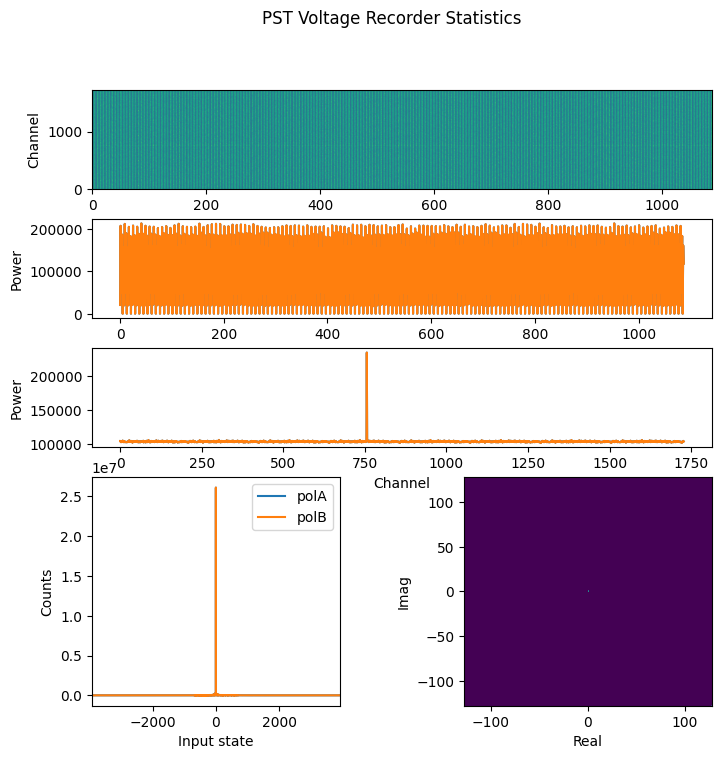

In [10]:
plot_set_file(pcap_stat_file_name)